In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as sm
import warnings
warnings.filterwarnings("ignore")

### Import Data for XOM, XLE, and SPY

In [2]:
xom = yf.download('XOM', start='2018-01-01', end='2025-01-01')
xle = yf.download('XLE', start='2018-01-01', end='2025-01-01')
spy = yf.download('SPY', start='2018-01-01', end='2025-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
c2clr = pd.DataFrame()

# XOM
c2clr.index = xom.index
c2clr['XOM'] = np.NaN
for i in range (1, len(c2clr['XOM'])):
    c2clr['XOM'].iloc[i] = np.log(xom['Close'].iloc[i]) - np.log(xom['Close'].iloc[i-1])

# XLE
c2clr['XLE'] = np.NaN
for i in range (1, len(c2clr['XLE'])):
    c2clr['XLE'].iloc[i] = np.log(xle['Close'].iloc[i]) - np.log(xle['Close'].iloc[i-1])

# SPY
c2clr['SPY'] = np.NaN
for i in range (1, len(c2clr['SPY'])):
    c2clr['SPY'].iloc[i] = np.log(spy['Close'].iloc[i]) - np.log(spy['Close'].iloc[i-1])

c2clr.dropna(inplace=True)

Let's visualize the returns!

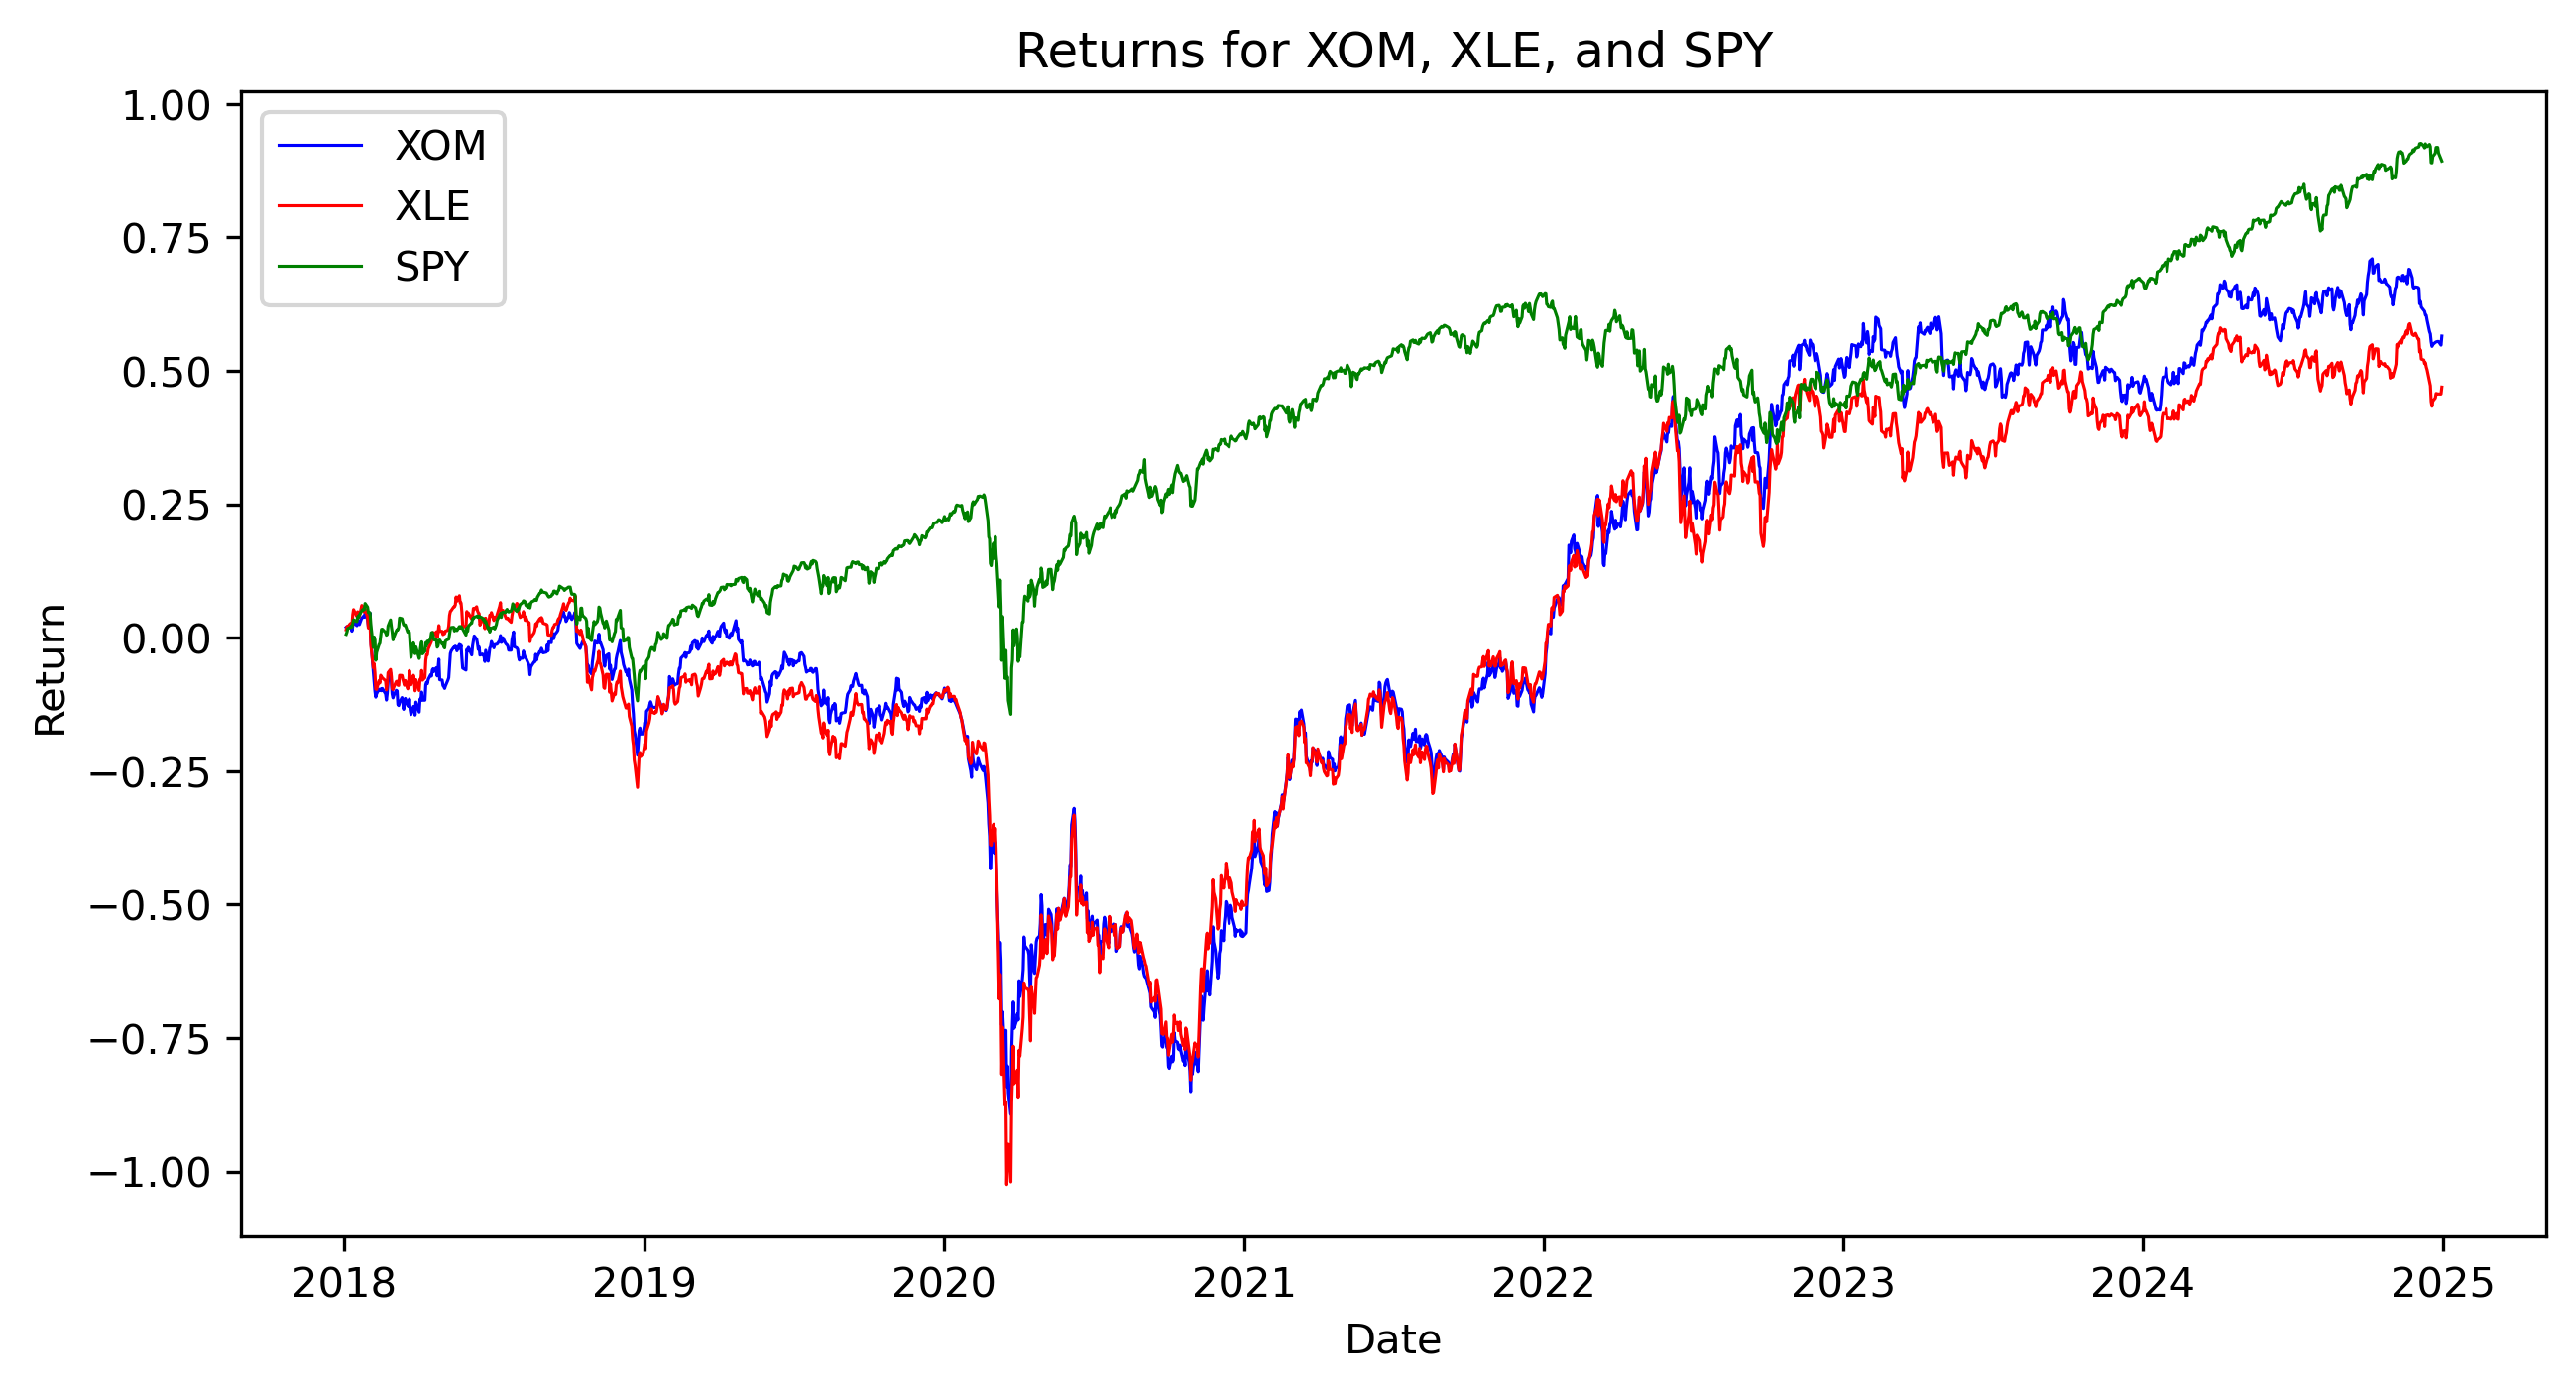

In [4]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(c2clr.index, c2clr['XOM'].cumsum(), label='XOM', color='blue', linewidth=0.75)
plt.plot(c2clr.index, c2clr['XLE'].cumsum(), label='XLE', color='red', linewidth=0.75)
plt.plot(c2clr.index, c2clr['SPY'].cumsum(), label='SPY', color='green', linewidth=0.75)
plt.xlabel("Date")
plt.ylabel("Return")
plt.title('Returns for XOM, XLE, and SPY')
plt.legend()
plt.show()

### Cointegration Analysis

In [5]:
model = sm.ols(formula='XOM ~ 1 + XLE + SPY', data=c2clr).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    XOM   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     5598.
Date:                Tue, 23 Sep 2025   Prob (F-statistic):               0.00
Time:                        23:08:30   Log-Likelihood:                 6187.9
No. Observations:                1760   AIC:                        -1.237e+04
Df Residuals:                    1757   BIC:                        -1.235e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0001      0.000      0.719      0.472      -0.000       0.000
XLE            0.9068      0.011     86.055      0.000       0.886       0.928
SPY           -0.0875      0.018     -4.927      0.000      -0.122      -0.053
==============================================================================
Omnibus:                      403.790   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12371.844
Skew:                           0.372   Prob(JB):                         0.00
Kurtosis:                      15.967   Cond. No.                         112.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
X = np.cumsum(model.resid)
Xdf = pd.DataFrame()
Xdf.index = X.index
Xdf['y'] = np.NaN
Xdf['x'] = np.NaN
for i in range (1, len(Xdf.index)-1):
    Xdf['y'].iloc[i] = X.iloc[i+1]
    Xdf['x'].iloc[i] = X.iloc[i-1]
OUFit = sm.ols(formula='y ~ 1 + x', data=Xdf).fit()
OUFit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 5.904e+04
Date:                Tue, 23 Sep 2025   Prob (F-statistic):               0.00
Time:                        23:08:30   Log-Likelihood:                 5584.1
No. Observations:                1758   AIC:                        -1.116e+04
Df Residuals:                    1756   BIC:                        -1.115e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0005      0.000     -1.747      0.081      -0.001    5.87e-05
x              0.9854      0.004    242.991      0.000       0.977       0.993
==============================================================================
Omnibus:                      441.471   Durbin-Watson:                   1.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11528.724
Skew:                           0.569   Prob(JB):                         0.00
Kurtosis:                      15.494   Cond. No.                         16.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
varEta = np.var(OUFit.resid)
a, b = OUFit.params
k = -1 * np.log(b) * 252
m = a / (1-b)
sigma = np.sqrt((varEta * 2 * k) / (1 - b**2))
sigma_eq = np.sqrt(varEta / (1 - b**2))
[m, sigma_eq]

[-0.032766736906877744, 0.05927868339712044]

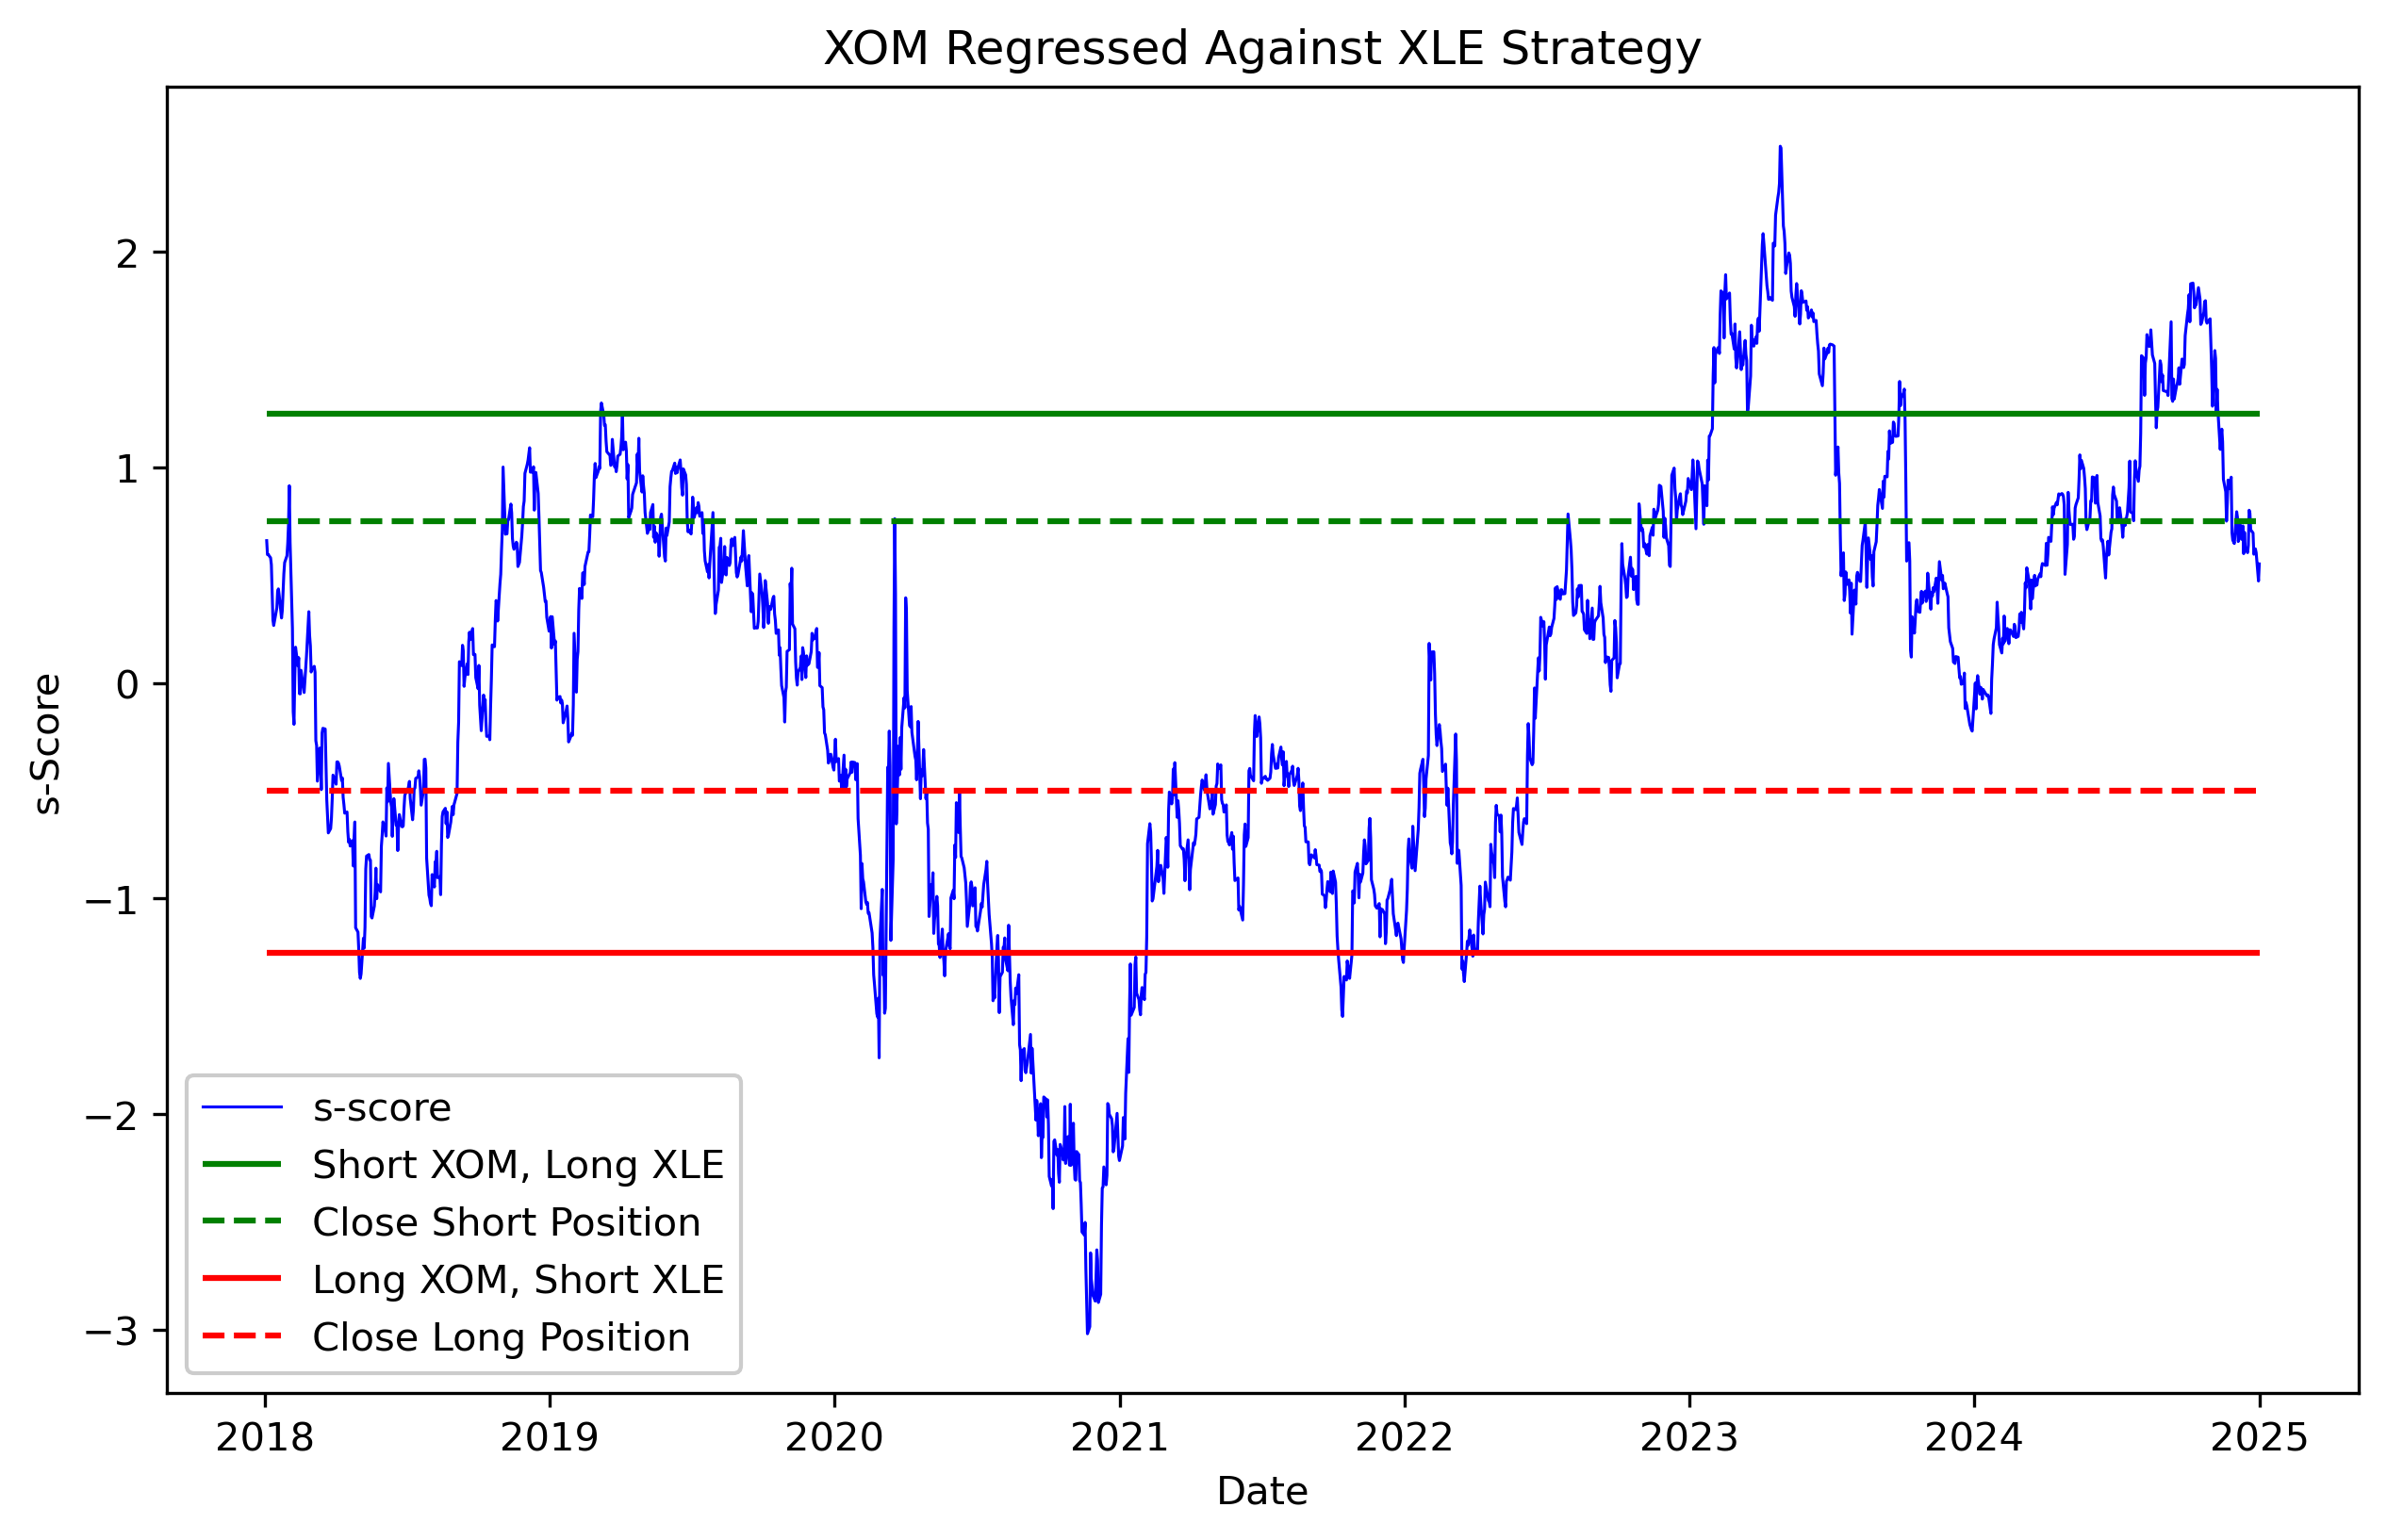

In [8]:
c2clr['sscore'] = (X - m) / sigma_eq
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(c2clr.index, c2clr.sscore, label="s-score", color='blue', linewidth=0.75)
xmin = c2clr.index[0]
xmax = c2clr.index[-1]
plt.hlines([1.25], xmin, xmax, color='green', label='Short XOM, Long XLE')
plt.hlines([0.75], xmin, xmax, color='green', linestyles='--', label='Close Short Position')
plt.hlines([-1.25], xmin, xmax, color='red', label='Long XOM, Short XLE')
plt.hlines([-0.5], xmin, xmax, color='red', linestyles='--', label='Close Long Position')
plt.xlabel("Date")
plt.ylabel("s-Score")
plt.title('XOM Regressed Against XLE Strategy')
plt.legend(framealpha=1, loc='lower left')
plt.show()

### Backtesting

In [9]:
paramsRes = []
for i in range(90, len(c2clr) - 90):
    # Subsetting c2clr
    c2clr_sub = c2clr.iloc[i:(i + 90), :]

    # Standardizing columns XOM, XLE, SPY
    c2clr_sub['XOM'] = (c2clr_sub['XOM'] - c2clr_sub['XOM'].mean()) / c2clr_sub['XOM'].std()
    c2clr_sub['XLE'] = (c2clr_sub['XLE'] - c2clr_sub['XLE'].mean()) / c2clr_sub['XLE'].std()
    c2clr_sub['SPY'] = (c2clr_sub['SPY'] - c2clr_sub['SPY'].mean()) / c2clr_sub['SPY'].std()

    # Regression model: XOM ~ XLE + SPY
    macroRegr = sm.ols('XOM ~ 1 + XLE + SPY', data=c2clr_sub).fit()

    # Cumulative sum of residuals
    residuals_macro = macroRegr.resid
    auxData = np.cumsum(residuals_macro)

    auxdf = pd.DataFrame()
    auxdf.index = auxData.index
    auxdf['y'] = np.NaN
    auxdf['x'] = np.NaN
    for j in range (1, len(auxdf.index)-1):
        auxdf['y'].iloc[j] = auxData.iloc[j+1]
        auxdf['x'].iloc[j] = auxData.iloc[j-1]

    ouRegr = sm.ols(formula='y ~ 1 + x', data=auxdf).fit()

    # Extracting required coefficients and calculating sigma, sigma_eq
    varEta = np.var(ouRegr.resid)
    a, b = ouRegr.params
    k = -np.log(b) * 252
    m = a / (1 - b)
    sigma = np.sqrt((varEta * 2 * k) / (1 - b**2))
    sigma_eq = np.sqrt(varEta / (1 - b**2))

    # Storing results in the list
    paramsRes.append({
        'Date': c2clr_sub.index[-1],
        'MacroBeta_XLE': macroRegr.params['XLE'],
        'MacroBeta_SPY': macroRegr.params['SPY'],
        'MacroAlpha': macroRegr.params['Intercept'],
        'VarEta': varEta,
        'OUA': a,
        'OUB': b,
        'OUK': k,
        'Sigma': sigma,
        'SigmaEQ': sigma_eq,
        'Score': -m / sigma_eq
    })

# Converting the results into a DataFrame
paramsRes_df = pd.DataFrame(paramsRes)

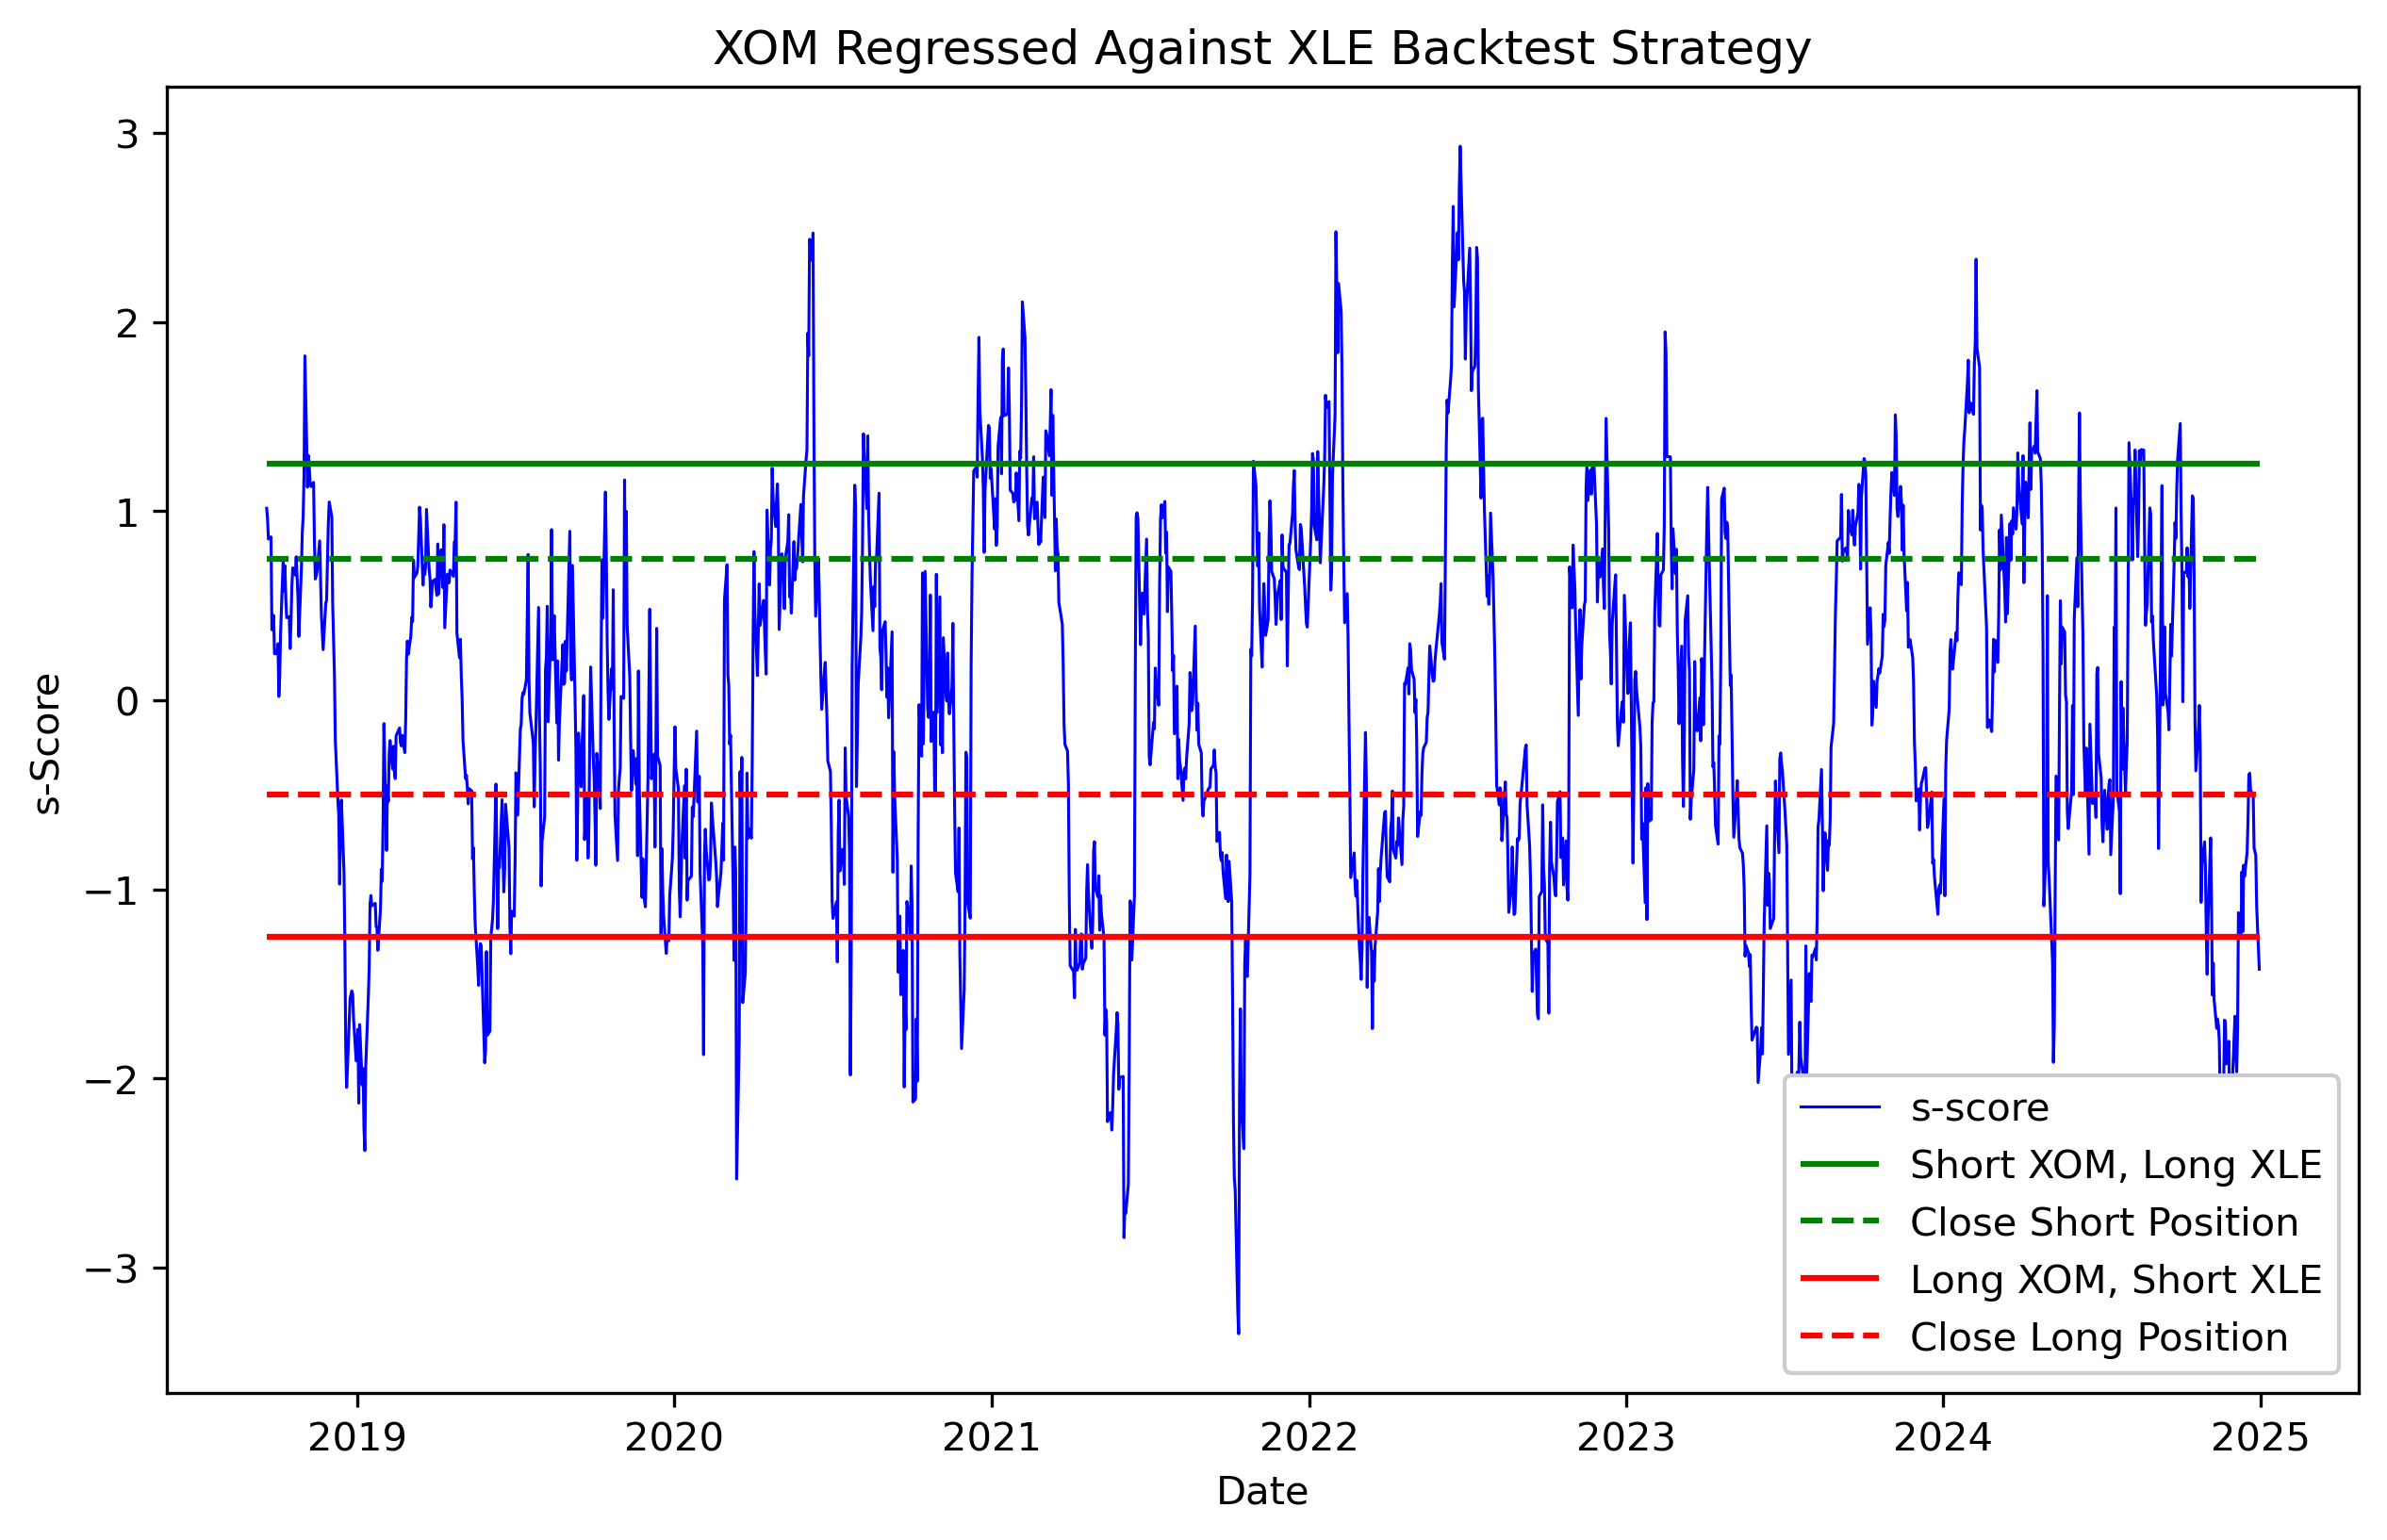

In [10]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(paramsRes_df.Date, paramsRes_df.Score, label="s-score", color='blue', linewidth=0.75)
xmin = paramsRes_df.Date.iloc[0]
xmax = paramsRes_df.Date.iloc[-1]
plt.hlines([1.25], xmin, xmax, color='green', label='Short XOM, Long XLE')
plt.hlines([0.75], xmin, xmax, color='green', linestyles='--', label='Close Short Position')
plt.hlines([-1.25], xmin, xmax, color='red', label='Long XOM, Short XLE')
plt.hlines([-0.5], xmin, xmax, color='red', linestyles='--', label='Close Long Position')
plt.xlabel("Date")
plt.ylabel("s-Score")
plt.title('XOM Regressed Against XLE Backtest Strategy')
plt.legend(framealpha=1, loc='lower right')
plt.show()

In [11]:
copyParamsRes_df = paramsRes_df.copy()
copyC2CLR = c2clr.copy()
paramsRes_df['XOM_Pos'] = 0
paramsRes_df['XLE_Pos'] = 0
paramsRes_df['SPY_Pos'] = 0

for i in range(1, len(paramsRes_df)):
    if paramsRes_df.OUK.iloc[i] > (252/30):
        if paramsRes_df.Score.iloc[i] >= 1.25:
            paramsRes_df.XOM_Pos.iloc[i] = -1
            paramsRes_df.XLE_Pos.iloc[i] = paramsRes_df.MacroBeta_XLE.iloc[i]
            paramsRes_df.SPY_Pos.iloc[i] = paramsRes_df.MacroBeta_SPY.iloc[i]
        elif paramsRes_df.Score.iloc[i] >= 0.75 and paramsRes_df.XOM_Pos.iloc[i-1] == -1:
            paramsRes_df.XOM_Pos.iloc[i] = -1
            paramsRes_df.XLE_Pos.iloc[i] = paramsRes_df.MacroBeta_XLE.iloc[i]    
            paramsRes_df.SPY_Pos.iloc[i] = paramsRes_df.MacroBeta_SPY.iloc[i]

        if paramsRes_df.Score[i] <= -1.25:
            paramsRes_df.XOM_Pos.iloc[i] = 1
            paramsRes_df.XLE_Pos.iloc[i] = -1 * paramsRes_df.MacroBeta_XLE.iloc[i]   
            paramsRes_df.SPY_Pos.iloc[i] = -1 * paramsRes_df.MacroBeta_SPY.iloc[i]
        elif paramsRes_df.Score.iloc[i] <= -0.5 and paramsRes_df.XOM_Pos.iloc[i-1] == 1:
            paramsRes_df.XOM_Pos.iloc[i] = 1
            paramsRes_df.XLE_Pos.iloc[i] = -1 * paramsRes_df.MacroBeta_XLE.iloc[i] 
            paramsRes_df.SPY_Pos.iloc[i] = -1 * paramsRes_df.MacroBeta_SPY.iloc[i]

In [12]:
c2clr['NextXOM'] = c2clr['XOM'].shift(-1)
c2clr['NextXLE'] = c2clr['XLE'].shift(-1)
c2clr['NextSPY'] = c2clr['SPY'].shift(-1)
c2clr.reset_index(inplace=True)

# Perform the left join on 'Date' column
paramsRes_df = pd.merge(paramsRes_df, c2clr[['Date', 'NextXOM', 'NextXLE', 'NextSPY']], on='Date', how='left')

# Calculate return
paramsRes_df['Return'] = (paramsRes_df['NextXOM'] * paramsRes_df['XOM_Pos'] +
                       paramsRes_df['NextXLE'] * paramsRes_df['XLE_Pos'] +
                       paramsRes_df['NextSPY'] * paramsRes_df['SPY_Pos'])

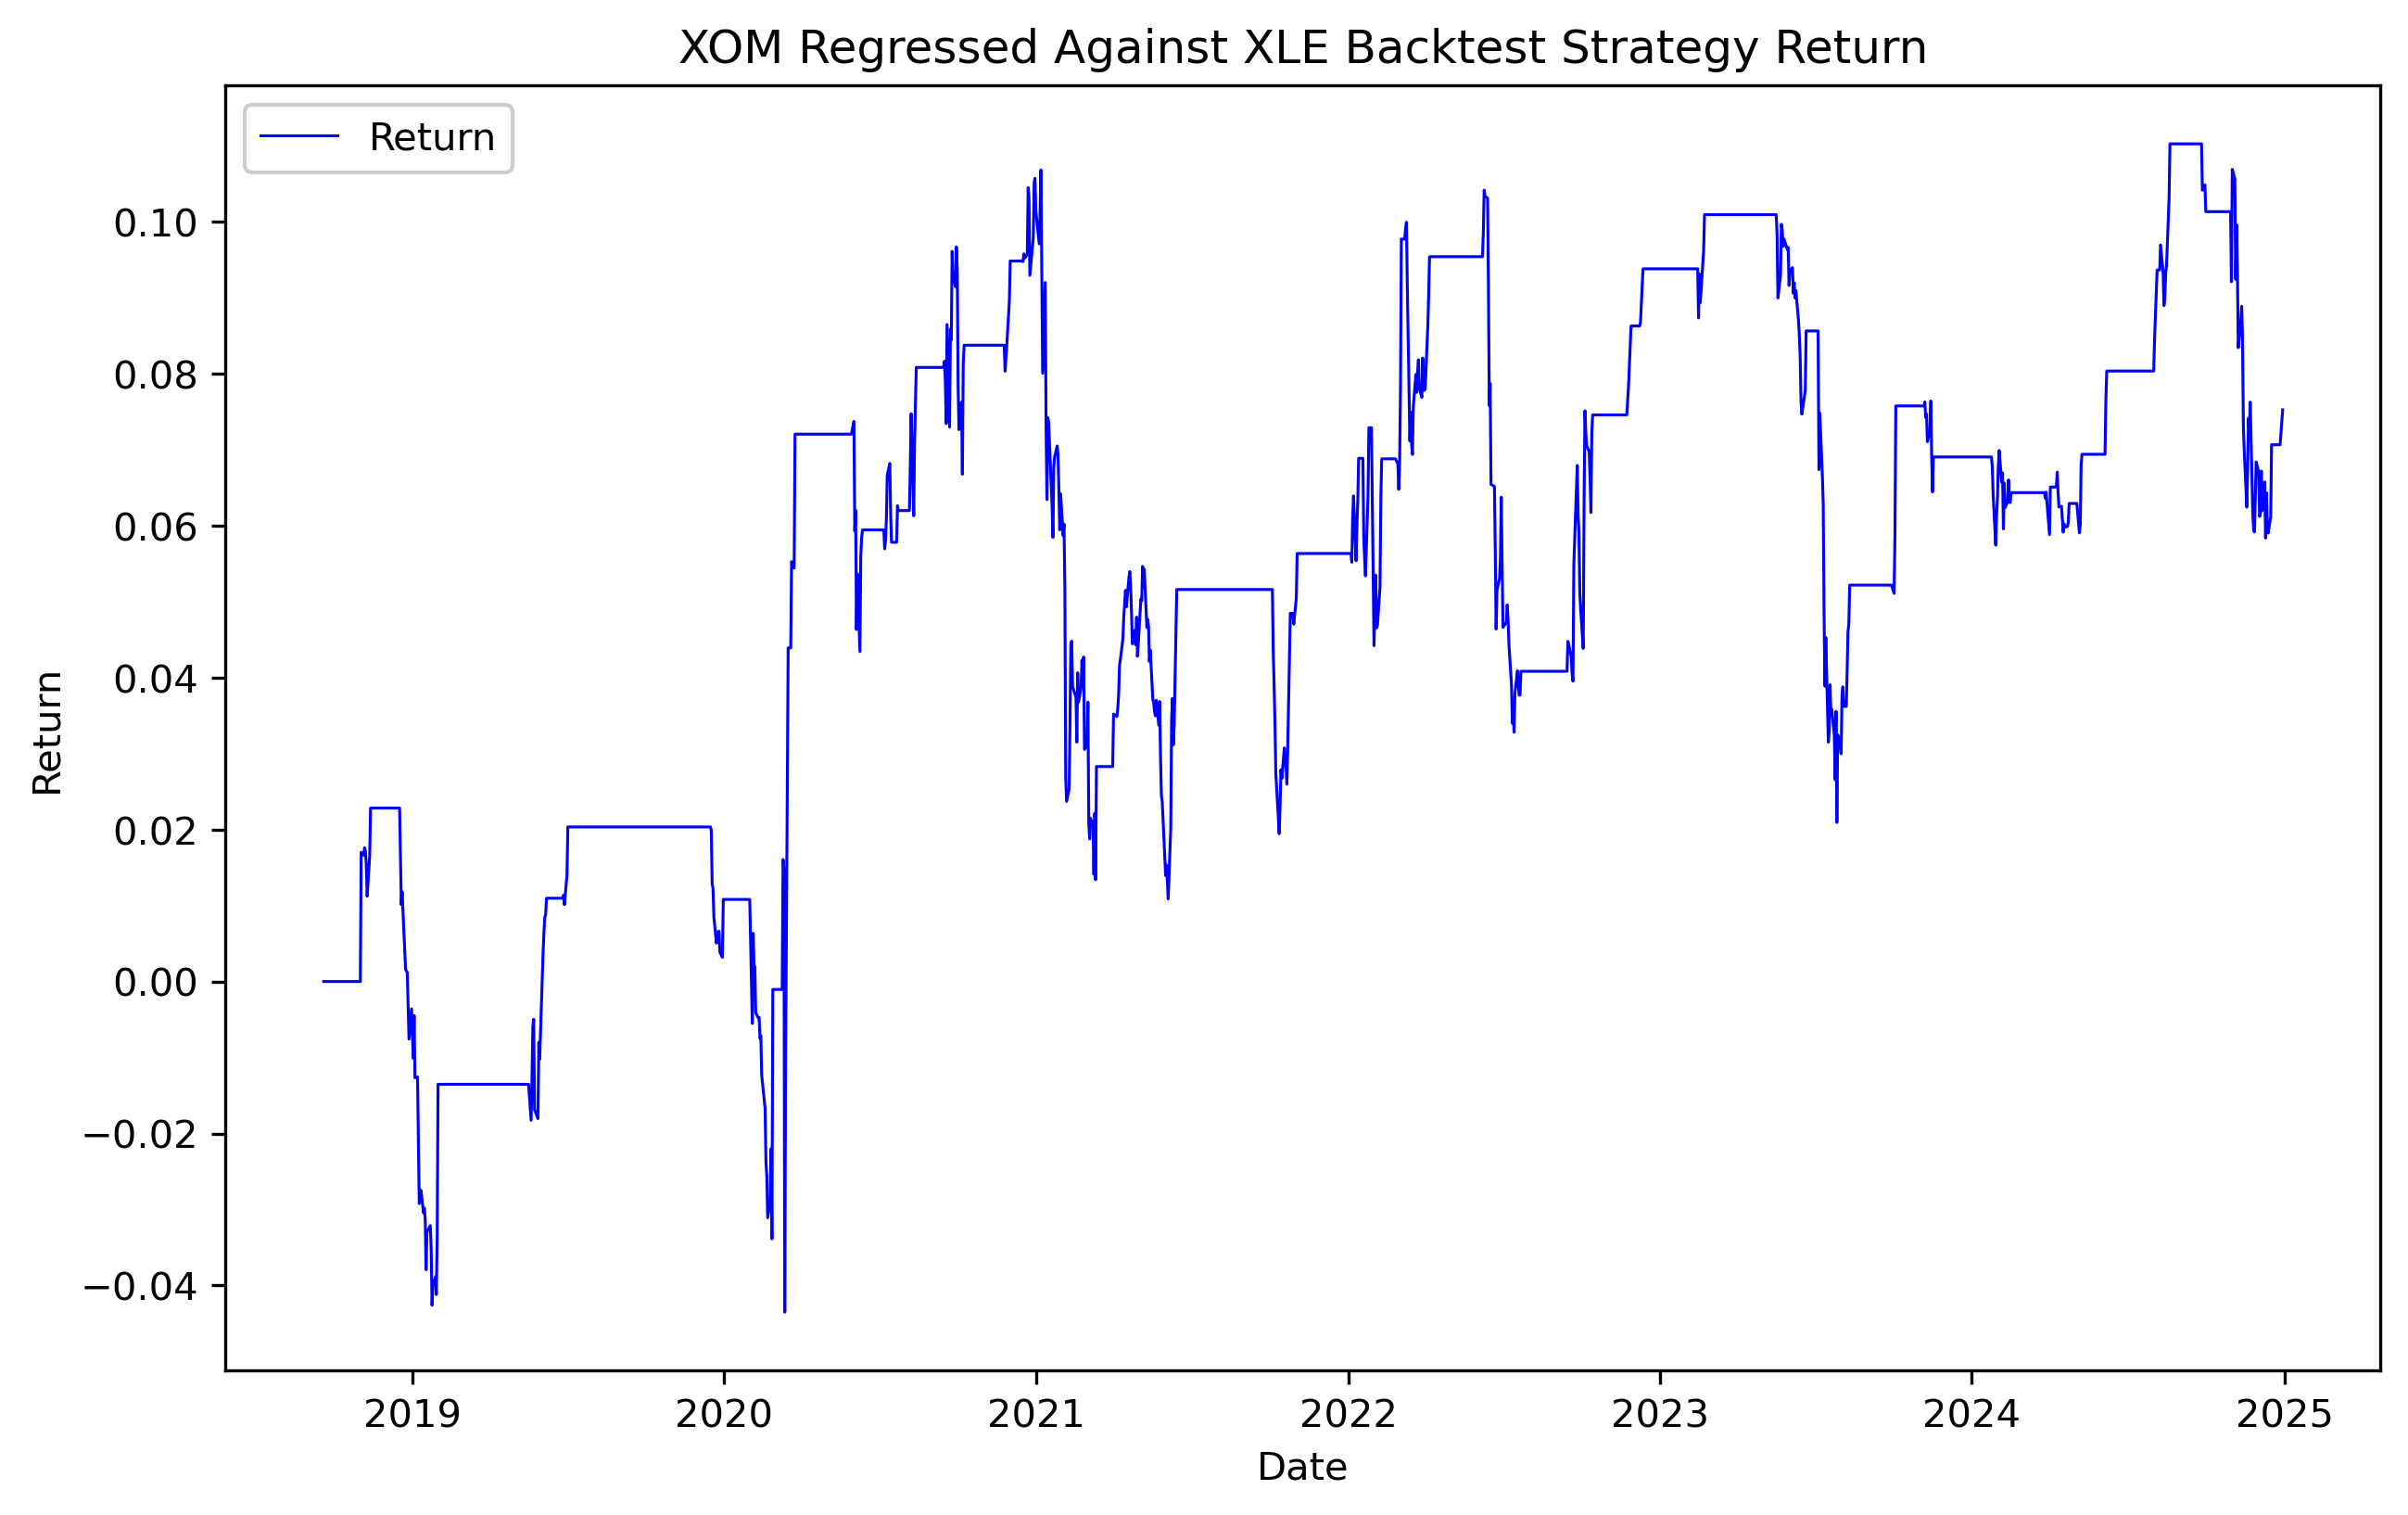

In [13]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(paramsRes_df.Date, np.cumsum(paramsRes_df.Return), label="Return", color='blue', linewidth=0.75)
plt.xlabel("Date")
plt.ylabel("Return")
plt.title('XOM Regressed Against XLE Backtest Strategy Return')
plt.legend(framealpha=1, loc='upper left')
plt.show()

In [14]:
print(f'Cumulative Return: {np.cumsum(paramsRes_df.Return).iloc[-1] * 100:.2f}%')
print(f'Sharpe Ratio: {paramsRes_df['Return'].mean() / paramsRes_df['Return'].std() * np.sqrt(252)}')
s = (paramsRes_df.Return+1).cumprod()
max_drawdown = np.ptp(s)/s.max()
print(f'Max Drawdown: {max_drawdown}')

Cumulative Return: 7.52%
Sharpe Ratio: 0.17072142035936283
Max Drawdown: 0.13634706324770923
